In [2]:
import pandas as pd
df = pd.read_excel('data_process_all.xlsx')

# 计算文本加权情感强度

In [3]:
#文本加权情感强度计算公式为：整体情感极性*K（是否为长文本）*（分词情感强度绝对值+emoji数量*3）/分词长度
#其中，整体情感极性由百度API提供；长文本权重为1.5，短文本权重为1
import numpy as np
df['weighted_score']=0
for i in range(len(df)):
    try:
        num_emoji=len(df['weibo_emoji'][i].split(","))
    except:
        num_emoji=0
    length=df['length'][i]
    emo_score=abs(df['emo_score'][i])
    if df['isLongText'][i]:
        k=1.5
    else:
        k=1
    if df['baidu_pm'][i]=="正向":
        emo=1
    else:
        emo=-1
    df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
df['weighted_score']=df['weighted_score'].fillna(value=0)
df['weighted_score'][np.isinf(df['weighted_score'])] = 0

C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_21052\294634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_21052\294634369.py:20: RuntimeWarning: invalid value encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_21052\294634369.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_21052\294634369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

# 微博话题强度计算

In [149]:
#情感强度第一定律公式μ=K*log(1+△p)，其中K与事件
#价值率高差计算公式：△p=(Ci-Cmin)/(Cmax-Cmin),其中i为时间戳，C为时间戳中转评赞总和
import datetime
#数据是从22年2月到23年四月底，其中由于23.4.7官方发布相关消息，讨论度变化较大，故取前后一段时间舆论强度变化作为示例
# 在这里修改始末时间参数
START=datetime.datetime.strptime("2023-4-7 11:30:00", '%Y-%m-%d %H:%M:%S')
END=datetime.datetime.strptime("2023-4-7 21:30:00", '%Y-%m-%d %H:%M:%S')

#划分时间戳
start=[]
end=[]
h=1/3  # 采样频率，比如2小时采样一次（单位：hr）
begin=START
while begin<END:
    start.append(begin)
    end.append(begin+datetime.timedelta(hours=h))
    begin=begin+datetime.timedelta(hours=h)

C=[0 for i in range(len(start))]
Stext=[0 for i in range(len(start))]
for i in range(len(df)):
    time=df['created_at'][i]
    count=df['comments_count'][i]+df['attitudes_count'][i]+df['reposts_count'][i]+1 #计数=转赞评+文本
    score=df['weighted_score'][i]
    for j in range(len(start)):
        if time>=start[j] and time<end[j]:
            C[j]+=count
            Stext[j]+=score
Stopic=[0 for i in range(len(start))]
for j in range(len(C)):
    p=(C[j]-min(C))/(max(C)-min(C))
    Stopic[j]=2*np.log(1+p)

# 综合情感计算及舆情变化趋势检测
- start: 每个时间窗口的起始时间
- SE: 每个时间窗口上的综合情感得分

In [150]:
SE=[0 for i in range(len(start))]
for i in range(len(C)):
    SE[i]=abs(Stext[i]*Stopic[i]/2)

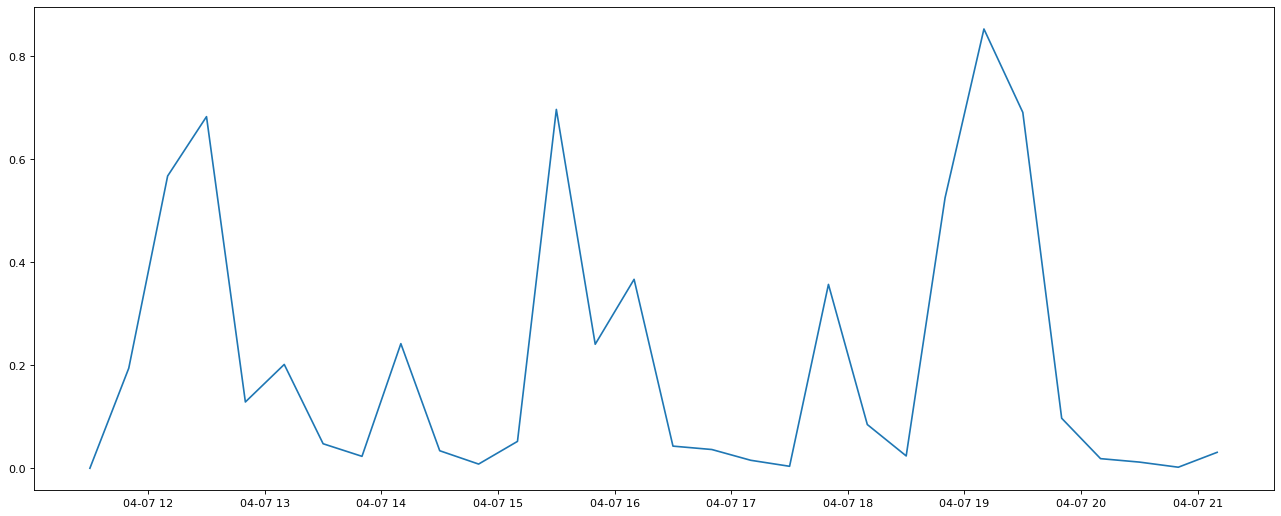

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start,SE)

In [153]:
#舆情变化率近似于(SEt+1-SEt)/T
#其中T为时间间隔，即一个时间戳长度
y=[(SE[i+1]-SE[i])/h for i in range(len(SE)-1)]

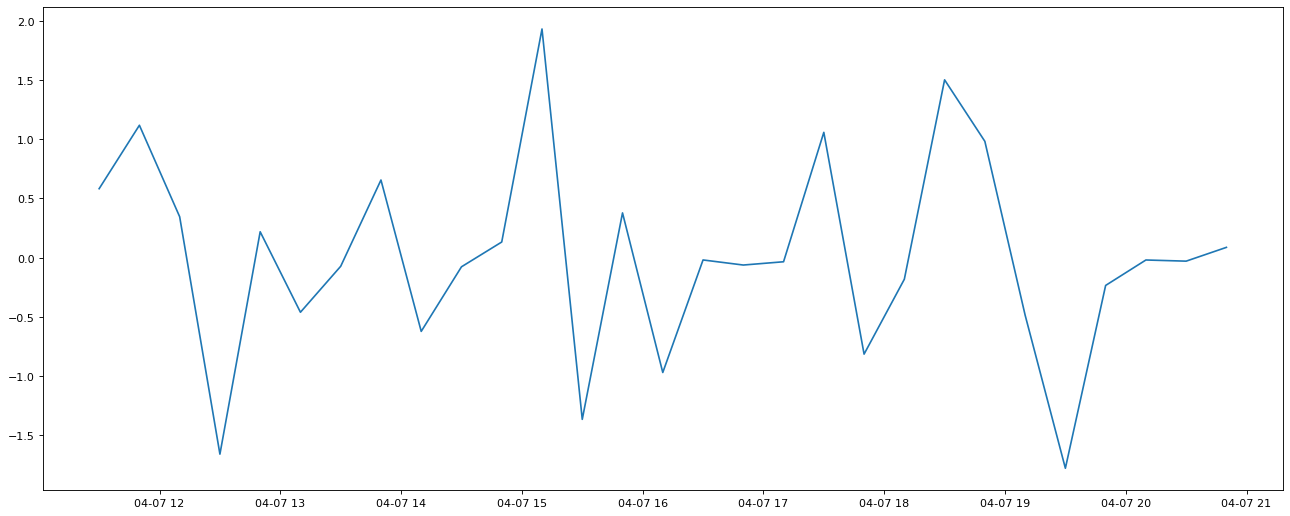

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start[:len(start)-1],y)

# time series forecast

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
torch.set_default_tensor_type(torch.DoubleTensor)

In [ ]:
# 模型评估指标,mape
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100   

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# 在测试集上Forecast
# 采用rolling的形式
# history是列表形式
def forecast_h_steps(model, history, LOOKBACK, h):
    # 第一个data_X就是history的最后几个观测
    data_X = history[-LOOKBACK:]
    
    
    # 新建一个列表存储forecasts
    forecasts = []
    
    for i in range(h):
        
        # 处理成tensor
        data_X = np.array(data_X).reshape(-1, 1, LOOKBACK)
        data_X = torch.from_numpy(data_X)
        data_X = Variable(data_X)
        
        # 预测下一个点
        new_forecast = model.forward(data_X).item()
        
        # 更新入forecasts
        forecasts.append(new_forecast)
        
        # 更新data_X: 窗口向后滑动一步，加上新的forecast
        data_X = list(data_X.view(-1).data.numpy())
        data_X = data_X[-(LOOKBACK-1):] + [new_forecast]
    
        
    return forecasts

In [177]:
# LOOBACK: 以前的时间步数用作输入变量来预测下一个时间步
LOOKBACK = 3

#数据预处理
dataset = SE
train_size = int(len(dataset) * 0.7)
test_size = len(dataset)-train_size
# 一刀切分成train, test
dataset_train = dataset[:-test_size]
dataset_test = dataset[-test_size:]

# 标准化
# max_value = np.max(dataset)
# min_value = np.min(dataset)
# scalar = max_value-min_value
# dataset = list(map(lambda x: x/scalar, dataset))  # 将数据标准化到0~1之间


def create_dataset(dataset, look_back=LOOKBACK):  
    data_X, data_y=[], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]  
        data_X.append(a)
        data_y.append(dataset[i+look_back])  
    return np.array(data_X), np.array(data_y)  


train_X, train_y = create_dataset(dataset_train)

 
train_X = train_X.reshape(-1,1,LOOKBACK)  # 第一个维度为batch
train_y = train_y.reshape(-1,1,1)


train_X = torch.from_numpy(train_X)  # ndarray转化成tensor
train_y = torch.from_numpy(train_y)



## 1. LSTM

In [181]:
# 创建lstm类
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg,self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) 
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):   
        x, _ = self.rnn(x)
        s,b,h = x.shape
        x = x.view(s*b, h)  # 输出变为（s*b）*h的二维
        x = self.reg(x)
        x = x.view(s,b,-1)  # 卷积的输出从外到里的维数为s,b,一列
        return x

# 数据点有限且结构简单，只用3个神经元够够的了
HIDDEN_SIZE = 3
net = lstm_reg(LOOKBACK, HIDDEN_SIZE) 

# 定义一堆训练参数
loss_fn = nn.MSELoss()  
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)


# 开始训练
for epoch in range(3000):
    var_X = Variable(train_X)  # 转换为带梯度的Variable
    var_y = Variable(train_y)
    var_X = var_X.to(torch.float64)
 
    out = net(var_X)
    loss = loss_fn(out, var_y)
 
    optimizer.zero_grad()  # 梯度置零
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数
    if (epoch + 1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))

# 保存训练文件
torch.save(net.state_dict(), 'net_params.pkl')

Epoch: 100, Loss:0.28072
Epoch: 200, Loss:0.08579
Epoch: 300, Loss:0.08033
Epoch: 400, Loss:0.07546
Epoch: 500, Loss:0.07100
Epoch: 600, Loss:0.06680
Epoch: 700, Loss:0.06267
Epoch: 800, Loss:0.05831
Epoch: 900, Loss:0.05327
Epoch: 1000, Loss:0.04709
Epoch: 1100, Loss:0.04001
Epoch: 1200, Loss:0.03262
Epoch: 1300, Loss:0.02400
Epoch: 1400, Loss:0.01225
Epoch: 1500, Loss:0.00836
Epoch: 1600, Loss:0.00636
Epoch: 1700, Loss:0.00456
Epoch: 1800, Loss:0.00309
Epoch: 1900, Loss:0.00215
Epoch: 2000, Loss:0.00158
Epoch: 2100, Loss:0.00122
Epoch: 2200, Loss:0.00099
Epoch: 2300, Loss:0.00082
Epoch: 2400, Loss:0.00067
Epoch: 2500, Loss:0.00053
Epoch: 2600, Loss:0.00041
Epoch: 2700, Loss:0.00033
Epoch: 2800, Loss:0.00026
Epoch: 2900, Loss:0.00021
Epoch: 3000, Loss:0.00017


In [182]:
# 加载模型并导入参数
net = lstm_reg(input_size=LOOKBACK, hidden_size=HIDDEN_SIZE)
net.load_state_dict(torch.load('net_params.pkl')) 

# train部分：拟合情况
train_X = train_X.reshape(-1, 1, LOOKBACK)
fitted_values = net.forward(train_X)
fitted_values = fitted_values.view(-1).data.numpy()

# test部分：forecast情况
forecasts = forecast_h_steps(net, dataset_train, LOOKBACK, h=test_size)

# 输出accuracy
accuracy_lstm = rmse(dataset[-test_size:], forecasts)

print('test accuracy:', accuracy_lstm)

test accuracy: 0.4876861128310817


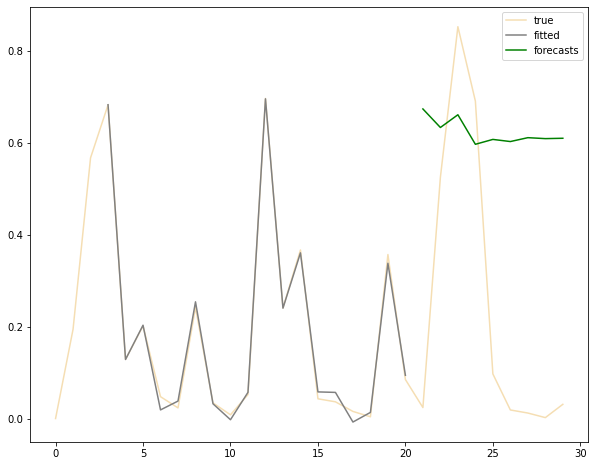

In [183]:
# 画图
plt.figure(figsize=(10, 8))
fitted_idx = [i for i in range(LOOKBACK, train_size)]
forecasts_idx = [i for i in range(train_size, train_size + test_size)]
plt.plot(dataset, 'wheat', label = 'true')
plt.plot(fitted_idx, fitted_values, 'grey', label = 'fitted')
plt.plot(forecasts_idx, forecasts, 'green', label = 'forecasts')
plt.legend()

## 2. MLP

In [19]:
# 创建MLP类
class mlp_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(mlp_reg,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.relu3 = nn.ReLU()
        self.reg = nn.Linear(hidden_size[2], output_size)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.reg(x)

        return x

In [184]:
# 数据点有限且结构简单，只用3个神经元够够的了
HIDDEN_SIZE = [10, 10, 10]
net = mlp_reg(LOOKBACK, HIDDEN_SIZE) 

# 定义一堆训练参数
loss_fn = nn.MSELoss()  
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)


# 开始训练
for epoch in range(3000):
    var_X = Variable(train_X)  # 转换为带梯度的Variable
    var_y = Variable(train_y)
    var_X = var_X.to(torch.float64)
 
    out = net(var_X)
    loss = loss_fn(out, var_y)
 
    optimizer.zero_grad()  # 梯度置零
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数
    if (epoch + 1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))

# 保存训练文件
torch.save(net.state_dict(), 'net_params_mlp.pkl')

Epoch: 100, Loss:0.04219
Epoch: 200, Loss:0.03215
Epoch: 300, Loss:0.02185
Epoch: 400, Loss:0.01752
Epoch: 500, Loss:0.01290
Epoch: 600, Loss:0.00910
Epoch: 700, Loss:0.00630
Epoch: 800, Loss:0.00394
Epoch: 900, Loss:0.00310
Epoch: 1000, Loss:0.00237
Epoch: 1100, Loss:0.00176
Epoch: 1200, Loss:0.00139
Epoch: 1300, Loss:0.00119
Epoch: 1400, Loss:0.00103
Epoch: 1500, Loss:0.00091
Epoch: 1600, Loss:0.00080
Epoch: 1700, Loss:0.00070
Epoch: 1800, Loss:0.00059
Epoch: 1900, Loss:0.00048
Epoch: 2000, Loss:0.00035
Epoch: 2100, Loss:0.00023
Epoch: 2200, Loss:0.00012
Epoch: 2300, Loss:0.00005
Epoch: 2400, Loss:0.00002
Epoch: 2500, Loss:0.00001
Epoch: 2600, Loss:0.00001
Epoch: 2700, Loss:0.00001
Epoch: 2800, Loss:0.00001
Epoch: 2900, Loss:0.00001
Epoch: 3000, Loss:0.00001


In [185]:
# 加载模型并导入参数
net = mlp_reg(input_size=LOOKBACK, hidden_size=HIDDEN_SIZE)
net.load_state_dict(torch.load('net_params_mlp.pkl')) 

# train部分：拟合情况
train_X = train_X.reshape(-1, 1, LOOKBACK)
fitted_values = net.forward(train_X)
fitted_values = fitted_values.view(-1).data.numpy()

# test部分：forecast情况
forecasts = forecast_h_steps(net, dataset_train, LOOKBACK, h=test_size)

# 输出accuracy
accuracy_mlp = rmse(dataset[-test_size:], forecasts)

print('test accuracy:', accuracy_mlp)

test accuracy: 0.2552818353675211


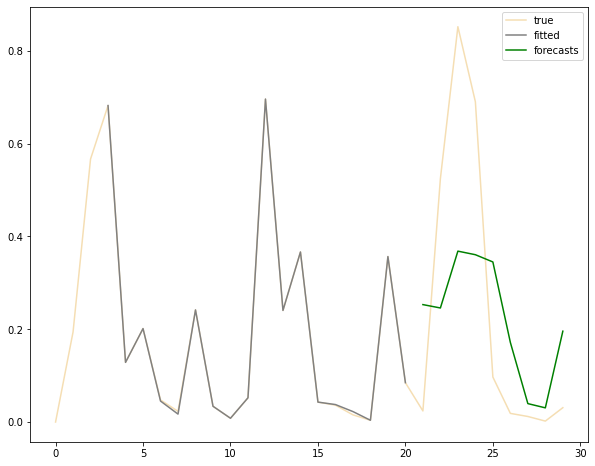

In [186]:
# 画图
plt.figure(figsize=(10, 8))
fitted_idx = [i for i in range(LOOKBACK, train_size)]
forecasts_idx = [i for i in range(train_size, train_size + test_size)]
plt.plot(dataset, 'wheat', label = 'true')
plt.plot(fitted_idx, fitted_values, 'grey', label = 'fitted')
plt.plot(forecasts_idx, forecasts, 'green', label = 'forecasts')
plt.legend()